# Spark Collaborative Filtering using Alternating Least Squares (ALS)

A self contained notebook that uses MovieLens dataset, processes it and implements Spark collaborative filtering algorithm.

In [1]:
import sys
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pyspark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType

from recommenders.datasets import movielens
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.datasets.spark_splitters import spark_random_split

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))

c:\Users\ashwi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


System version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Pandas version: 1.4.2
PySpark version: 3.3.2


Preparing schema with column names

In [62]:
MOVIELENS_DATA_SIZE = "100k"

COL_USER = "UserId"
COL_ITEM = "MovieId"
COL_RATING = "Rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "Timestamp"

In [63]:
schema = StructType((
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField(COL_TIMESTAMP, LongType()),))

In [64]:
print(schema)

StructType([StructField('UserId', IntegerType(), True), StructField('MovieId', IntegerType(), True), StructField('Rating', FloatType(), True), StructField('Timestamp', LongType(), True)])


Model hyper parameters 

In [65]:
RANK = 10
MAX_ITER = 15
REG_PARAM = 0.05
K = 10 # number of recommended items

Initialize a Spark session.

In [67]:
spark = start_or_get_spark("ALS Deep Dive", memory="16g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

LOADING DATA

In [69]:
dfs = movielens.load_spark_df(spark=spark, size=MOVIELENS_DATA_SIZE, schema=schema)

100%|██████████| 4.81k/4.81k [00:03<00:00, 1.28kKB/s]


In [9]:
dfs.show(5)

+------+-------+------+---------+
|UserId|MovieId|Rating|Timestamp|
+------+-------+------+---------+
|   196|    242|   3.0|881250949|
|   186|    302|   3.0|891717742|
|    22|    377|   1.0|878887116|
|   244|     51|   2.0|880606923|
|   166|    346|   1.0|886397596|
+------+-------+------+---------+
only showing top 5 rows



Data is randomly split in the ratio of 75:25 for training and testing.

In [70]:
dfs_train, dfs_test = spark_random_split(dfs, ratio=0.75, seed=42)

ALS Model Training

In [71]:
als = ALS(
    maxIter=MAX_ITER, 
    rank=RANK,
    regParam=REG_PARAM, 
    userCol=COL_USER, 
    itemCol=COL_ITEM, 
    ratingCol=COL_RATING, 
    coldStartStrategy="drop" # Spark ALS allows for dropping cold users for robust model training
)

model = als.fit(dfs_train)

MODEL PREDICTION

In [72]:
dfs_pred = model.transform(dfs_test)

In [73]:
type(dfs_pred), type(dfs_test)

(pyspark.sql.dataframe.DataFrame, pyspark.sql.dataframe.DataFrame)

PERFORMANCE EVALUATION

In [78]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='Rating', predictionCol='prediction')
print('The root mean squared error the our model is: {}'.format(evaluator.evaluate(dfs_pred)))

evaluator_mae = RegressionEvaluator(metricName='mae', labelCol='Rating', predictionCol='prediction')
print('The mean absolute error the our model is: {}'.format(evaluator_mae.evaluate(dfs_pred)))

evaluator_r2 = RegressionEvaluator(metricName='r2', labelCol='Rating', predictionCol='prediction')
print('The R2 score for the model is: {}'.format(evaluator_r2.evaluate(dfs_pred)))

The root mean squared error the our model is: 0.9677175964664096
The mean absolute error the our model is: 0.7528439718712303
The R2 score for the model is: 0.2599832348998994


In [79]:
# Get the cross join of all user-item pairs and score them.
users = dfs_train.select(COL_USER).distinct()
items = dfs_train.select(COL_ITEM).distinct()
user_item = users.crossJoin(items)
dfs_pred = model.transform(user_item)

# Remove seen items to ensure that recommended items are different from those already rated by users
dfs_pred_exclude_train = dfs_pred.alias("pred").join(
    dfs_train.alias("train"),
    (dfs_pred[COL_USER] == dfs_train[COL_USER]) & (dfs_pred[COL_ITEM] == dfs_train[COL_ITEM]),
    how='outer'
)

dfs_pred_final = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
    .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

dfs_pred_final.show()

+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|     1|      7|   4.37756|
|     1|     20| 3.8920481|
|     1|     46|  3.647952|
|     1|    117| 3.2435613|
|     1|    255| 2.2684302|
|     1|    284|   3.06191|
|     1|    285| 4.5317836|
|     1|    318| 3.8725307|
|     1|    325| 2.5372407|
|     1|    328| 2.6743321|
|     1|    329|  3.216887|
|     1|    334| 2.1421502|
|     1|    335| 2.2832787|
|     1|    353| 3.5235739|
|     1|    370|  2.515941|
|     1|    371| 2.8664246|
|     1|    372| 4.4668136|
|     1|    381|  3.530128|
|     1|    391| 2.0390136|
|     1|    398| 0.9647004|
+------+-------+----------+
only showing top 20 rows



MODEL FINE-TUNING

- Parameter tuning not only helps in improving model performance, but also helps understand how various parameters affect the model. In this study, *rank* and *regParam* are tuned. 
- The default value of *rank* is 10.
- The default value of *regParam* is 1.0
- A list of values ```[10, 15, 20]``` for *rank* and a list of ```[0.001, 0.1, 1.0]``` for *regParam* is passed.

In [26]:
param_dict = {
    "rank": [10, 15, 20],
    "regParam": [0.001, 0.1, 1.0]
}

In [58]:
param_grid = generate_param_grid(param_dict) # dictionary of all parameter combination
param_grid

[{'rank': 10, 'regParam': 0.001},
 {'rank': 10, 'regParam': 0.1},
 {'rank': 10, 'regParam': 1.0},
 {'rank': 15, 'regParam': 0.001},
 {'rank': 15, 'regParam': 0.1},
 {'rank': 15, 'regParam': 1.0},
 {'rank': 20, 'regParam': 0.001},
 {'rank': 20, 'regParam': 0.1},
 {'rank': 20, 'regParam': 1.0}]

In [35]:
rmse_score = [] # record rmse scores for each param combination

for g in param_grid:
    als = ALS(        
        userCol=COL_USER, 
        itemCol=COL_ITEM, 
        ratingCol=COL_RATING, 
        coldStartStrategy="drop",
        **g
    )
    
    model = als.fit(dfs_train)
    
    dfs_pred = model.transform(dfs_test)
    
    rmse_score.append(evaluator.evaluate(dfs_pred))

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))) 

In [36]:
rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

<AxesSubplot:xlabel='reg. parameter', ylabel='rank'>

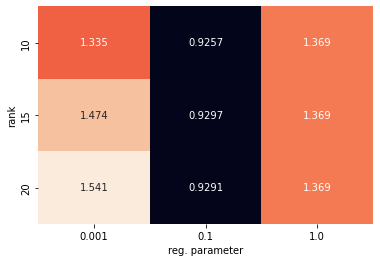

In [37]:
fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")

The calculated RMSE scores is visualized to comparatively study how model performance is affected by different parameters.

TOP k RECOMMENDATIONS FOR ALL USERS

In [ ]:
k = 10

In [38]:
dfs_rec = model.recommendForAllUsers(k)

In [39]:
dfs_rec.show(10)

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|     1|[{1536, 3.8911986...|
|     3|[{1536, 3.1063838...|
|     6|[{1536, 3.7354305...|
|    12|[{1536, 4.4471893...|
|    13|[{1536, 3.3997416...|
|    16|[{1536, 4.5658073...|
|    20|[{1536, 3.3140032...|
|    22|[{1536, 3.7392457...|
|    26|[{1536, 3.172992}...|
|    27|[{1536, 3.4825764...|
+------+--------------------+
only showing top 10 rows



TOP k RECOMMENDATIONS FOR RANDOM 3 USERS

In [40]:
users = dfs_train.select(als.getUserCol()).distinct().limit(3)

dfs_rec_subset = model.recommendForUserSubset(users, k)

In [50]:
users.show()

+------+
|UserId|
+------+
|   148|
|   463|
|   471|
+------+



In [55]:
dfs_rec_subset.show(truncate=False)

+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|UserId|recommendations                                                                                                                                                                            |
+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|471   |[{1536, 3.3287528}, {814, 3.325921}, {1306, 3.2876728}, {1642, 3.2444062}, {1467, 3.1962745}, {1599, 3.1828597}, {1500, 3.1590354}, {119, 3.1527188}, {1358, 3.1227164}, {1656, 3.0970337}]|
|463   |[{1536, 3.1125836}, {814, 3.109936}, {1306, 3.0741713}, {1642, 3.0337155}, {1467, 2.9887087}, {1599, 2.976165}, {1500, 2.953888}, {119, 2.9479823}, {1358, 2.919927}, {1656, 2.8959131}]   |
|148   |[{1536,

In [56]:
# cleanup spark instance
spark.stop()